# Preliminaries

In [1]:
import os.path
import datetime, time
import math

import pandas as pd
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
from matplotlib import cm
import msgpack

from stellarpunk import econ_sim, serialization

In [2]:
%load_ext autoreload
%autoreload 1
%aimport stellarpunk.serialization
%aimport stellarpunk.econ_sim

# Data Loading

## Economic Model

In [3]:
#production_chain_df = pd.DataFrame(msgpack.unpackb(open("/tmp/production_chain.log", "rb").read(), object_hook=serialization.decode_matrix))
production_chain = serialization.load_production_chain(open("/tmp/production_chain.log", "rb").read())
production_chain_df = production_chain.adj_matrix

In [4]:
production_chain_df.shape

(20, 20)

In [5]:
if os.path.exists("/tmp/agent_goods.log"):
    agent_goods_df = pd.DataFrame(msgpack.unpackb(open("/tmp/agent_goods.log", "rb").read(), object_hook=serialization.decode_matrix))
    #TODO: assumes every agent produces exactly one good
    agent_goods = agent_goods_df.idxmax(axis=1)
    loaded_agent_goods_from_file = True
else:
    loaded_agent_goods_from_file = False

## Loading Other Data

In [6]:
buy_price_df = serialization.read_tick_log_to_df(open("/tmp/buy_prices.log", "rb"), index_name="agent").reset_index()
buy_budget_df = serialization.read_tick_log_to_df(open("/tmp/buy_budget.log", "rb"), index_name="agent").reset_index()
sell_price_df = serialization.read_tick_log_to_df(open("/tmp/sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()
max_buy_price_df = serialization.read_tick_log_to_df(open("/tmp/max_buy_prices.log", "rb"), index_name="agent").reset_index()
min_sell_price_df = serialization.read_tick_log_to_df(open("/tmp/min_sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()

In [7]:
# if we were not able to load agent_goods_df above, infer it from sell prices now
if not loaded_agent_goods_from_file:
    g = sell_price_df.drop("tick", axis=1).groupby("agent").min()
    agent_goods_df = np.zeros((len(g),production_chain.num_products), dtype=int)
    agent_goods = np.full((len(g),), -3)
    for i in g.index:
        if g.loc[i].min() > 0:
            agent_goods_df[i,g.loc[i].argmin()] = 1
            agent_goods[i] = g.loc[i].argmin()
    agent_goods_df = pd.DataFrame(agent_goods_df)
    agent_goods = pd.Series(agent_goods)

In [8]:
production_goods = agent_goods_df @ production_chain_df.T

In [9]:
columns = ["tick", "product", "buyer", "seller", "price", "amount"]
transaction_df = pd.read_csv("/tmp/transactions.log", sep="\t", header=None, names=columns)

In [10]:
transaction_df["value"] = transaction_df["amount"] * transaction_df["price"]

In [11]:
# if you want to interpret tick as datetime in stellarpunk universe
#transaction_df["tick"] += time.mktime(datetime.datetime(2234, 4, 3).timetuple())
#transaction_df["tick"] = pd.to_datetime(transaction_df["tick"], unit="s")

In [12]:
cannot_buy_df = serialization.read_tick_log_to_df(open("/tmp/cannot_buy.log", "rb"), index_name="agent", fill_values=0.).reset_index()
cannot_sell_df = serialization.read_tick_log_to_df(open("/tmp/cannot_sell.log", "rb"), index_name="agent", fill_values=0.).reset_index()

In [13]:
balance_df = serialization.read_tick_log_to_df(open("/tmp/balance.log", "rb"), index_name="agent", column_names=["balance"])
balance_df.reset_index(inplace=True)

In [14]:
#columns = list(map(lambda x: str(x), range(production_chain_df.shape[0])))
columns=None
inventory_df = serialization.read_tick_log_to_df(open("/tmp/inventory.log", "rb"), index_name="agent", column_names=columns)
inventory_df.reset_index(inplace=True)

In [15]:
#production_efficiency_df = serialization.read_tick_log_to_df(open("/tmp/production_efficiency.log", "rb"), index_name="agent")

# Transactions

## Market Overview

In [16]:
transaction_df.groupby("product")[["amount", "value"]].sum()

,amount,value
product,,
0,306657.080844,4.919486e+06
1,452341.000000,2.125922e+06
2,202194.118123,2.540313e+06
3,118379.000000,2.873625e+06
4,20911.000000,2.458404e+06
5,44824.000000,1.974026e+06
6,22324.000000,1.553270e+06
7,12048.000000,2.804581e+06
8,8361.000000,5.469662e+06


In [17]:
#transaction_tick_grouping = "tick"
transaction_tick_grouping = transaction_df["tick"] // (5*60)

5581 transactions total


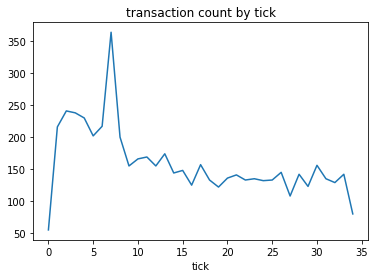

In [18]:
transaction_df.groupby(transaction_tick_grouping)["price"].count().plot()
plt.title("transaction count by tick")
print(f'{len(transaction_df)} transactions total')

Text(0.5, 1.0, 'product 0 transaction count per tick')

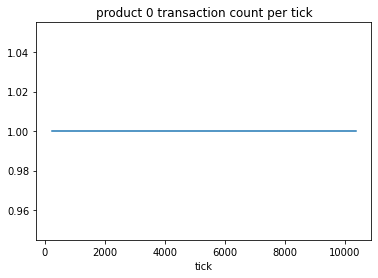

In [19]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].count().plot()
plt.title("product 0 transaction count per tick")

Text(0.5, 1.0, 'transaction unit quantity per tick')

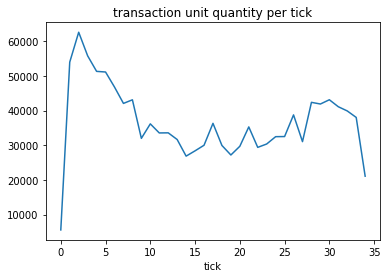

In [20]:
transaction_df.groupby(transaction_tick_grouping)["amount"].sum().plot()
plt.title("transaction unit quantity per tick")

Text(0.5, 1.0, 'transaction value per tick')

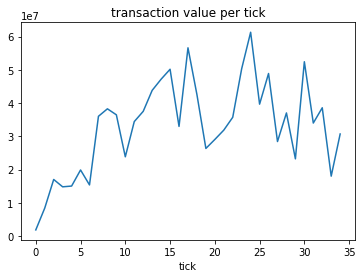

In [21]:
transaction_df.groupby(transaction_tick_grouping)["value"].sum().plot()
plt.title("transaction value per tick")

Text(0.5, 1.0, 'distinct products sold per tick')

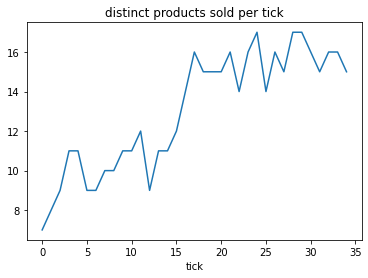

In [22]:
transaction_df.groupby(transaction_tick_grouping)["product"].nunique().plot()
plt.title("distinct products sold per tick") 

Text(0.5, 1.0, 'distinct sellers per tick')

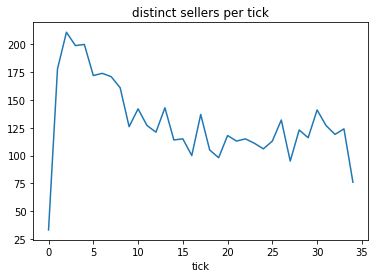

In [23]:
transaction_df.groupby(transaction_tick_grouping)["seller"].nunique().plot()
plt.title("distinct sellers per tick")

Text(0.5, 1.0, 'distinct buyers per tick')

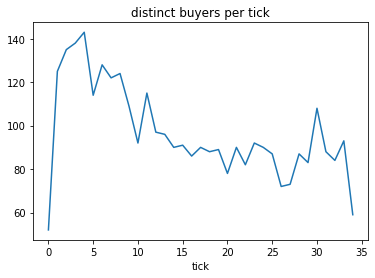

In [24]:
transaction_df.groupby(transaction_tick_grouping)["buyer"].nunique().plot()
plt.title("distinct buyers per tick")

In [25]:
transaction_df["seller"].nunique()

607

In [26]:
transaction_df["buyer"].nunique()

475

In [27]:
transaction_df["product"].nunique()

17

<AxesSubplot:>

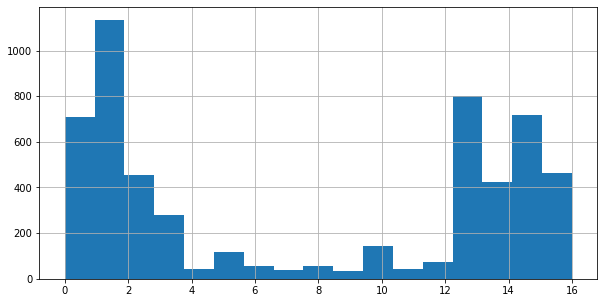

In [28]:
plt.figure(figsize=(10,5))
transaction_df["product"].hist(bins=transaction_df["product"].nunique())

Text(0.5, 1.0, 'max product id sold each tick')

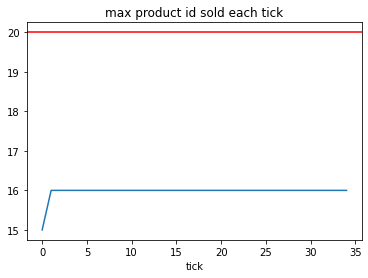

In [29]:
transaction_df.groupby(transaction_tick_grouping)["product"].max().plot()
plt.axhline(production_chain_df.shape[1], color="red")
plt.title("max product id sold each tick")

## Further Exploration

In [30]:
transaction_df[transaction_df["seller"] == 3]["price"].describe()

count     1.000000
mean     38.397866
std            NaN
min      38.397866
25%      38.397866
50%      38.397866
75%      38.397866
max      38.397866
Name: price, dtype: float64

Text(0.5, 1.0, 'price of product 0 over time')

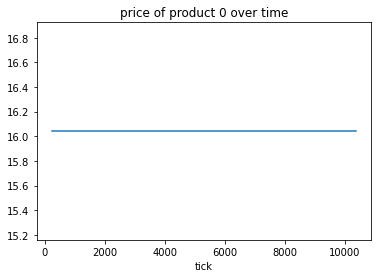

In [31]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].mean().plot()
plt.title("price of product 0 over time")

Text(0.5, 1.0, 'price of product 3 over time')

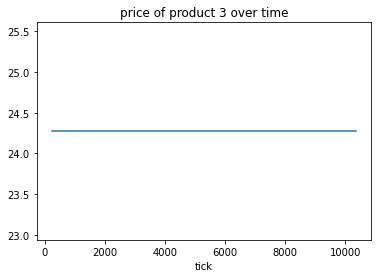

In [32]:
transaction_df[transaction_df["product"] == 3].groupby("tick")["price"].mean().plot()
plt.title("price of product 3 over time")

<AxesSubplot:>

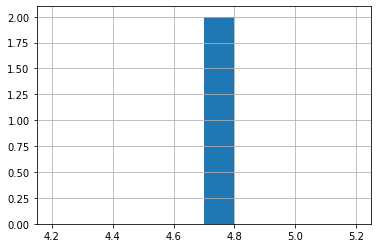

In [33]:
transaction_df[transaction_df["buyer"] == 3]["price"].hist()

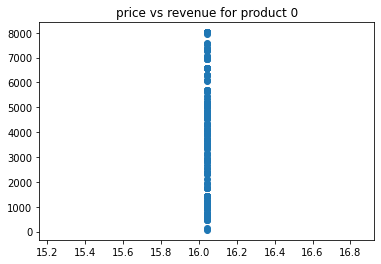

In [34]:
plt.scatter(transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 0].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 0")
plt.show()

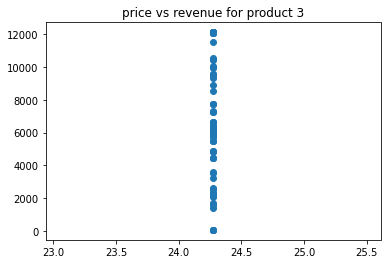

In [35]:
plt.scatter(transaction_df[transaction_df["product"] == 3].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 3].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 3")
plt.show()

In [36]:
transaction_df[(transaction_df["price"] > 12) & (transaction_df["product"] == 0)]

,tick,product,buyer,seller,price,amount,value
24,230.600000,0,785,783,16.042302,500.0,8021.151140
47,279.600000,0,492,490,16.042302,500.0,8021.151140
51,290.866667,0,785,756,16.042302,500.0,8021.151140
57,304.633333,0,492,460,16.042302,500.0,8021.151140
59,308.066667,0,54,8,16.042302,500.0,8021.151140
...,...,...,...,...,...,...,...
5566,10360.833333,0,943,976,16.042302,500.0,8021.151140
5567,10363.933333,0,34,36,16.042302,500.0,8021.151140
5568,10365.300000,0,943,926,16.042302,500.0,8021.151140
5572,10375.633333,0,497,476,16.042302,156.0,2502.599156


In [37]:
transaction_df.groupby("product").agg({"tick":"max", "price":"mean", "amount":"sum", "value":"sum"})

,tick,price,amount,value
product,,,,
0,10380.700000,16.042302,306657.080844,4.919486e+06
1,10355.366667,4.699822,452341.000000,2.125922e+06
2,10315.266667,12.563733,202194.118123,2.540313e+06
3,10357.000000,24.274787,118379.000000,2.873625e+06
4,10024.166667,118.058796,20911.000000,2.458404e+06
5,10345.400000,44.201487,44824.000000,1.974026e+06
6,10386.366667,69.648222,22324.000000,1.553270e+06
7,10385.066667,232.941528,12048.000000,2.804581e+06
8,10369.466667,654.439183,8361.000000,5.469662e+06


## Transaction Graph

### By Agent

In [38]:
transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index()

,buyer,seller,amount
0,0,13,500.0
1,0,19,500.0
2,0,22,500.0
3,0,36,107.0
4,0,39,251.0
...,...,...,...
2547,990,968,13.0
2548,990,970,1.0
2549,990,980,15.0
2550,990,982,1044.0


In [39]:
G = nx.from_pandas_edgelist(
    transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index(),
    source="seller", target="buyer", edge_attr="amount", create_using=nx.DiGraph)

In [40]:
labels = pd.DataFrame(transaction_df.groupby("seller")["product"].first()).apply(lambda x: f'{x.name}:{x["product"]}', axis=1)

In [41]:
G = nx.relabel_nodes(G, labels)

In [42]:
nx.is_directed_acyclic_graph(G)

False

In [43]:
# this is pretty slow for lots of agents
#plt.figure(figsize=(15, 15))
#pos = graphviz_layout(G, prog='dot')
#nx.draw(G, pos, with_labels=True, arrows=True)
#nx.draw_networkx_edge_labels(G, pos)
#plt.show()

### By Good

In [44]:
augmented_transaction_df = transaction_df.merge(agent_goods.rename("buyer_product"), how="left", left_on="buyer", right_index=True)
augmented_transaction_df["buyer_product"].fillna(-2, inplace=True)
product_flow = augmented_transaction_df.groupby(["product", "buyer_product"]).agg({"value":"sum", "amount":"sum"}).reset_index().rename({"buyer_product":"target", "product":"source"}, axis=1)

In [45]:
product_flow

,source,target,value,amount
0,0,4,4.919486e+06,306657.080844
1,1,5,2.125922e+06,452341.000000
2,2,6,2.540313e+06,202194.118123
3,3,7,2.873625e+06,118379.000000
4,4,-3,1.145316e+06,10864.000000
5,4,12,1.313088e+06,10047.000000
6,5,-3,8.701724e+05,22662.000000
7,5,11,1.103853e+06,22162.000000
8,6,-3,7.989621e+05,11662.000000
9,6,8,7.543080e+05,10662.000000


In [46]:
# discount intermediate sales by final sales
# this represents, e.g., traders carrying goods from one station to another
# if they completed their trade route we don't want to display that in the product flow graph
final_sales = product_flow[product_flow["target"] != -3].groupby("source")["amount"].sum()
final_sales_df = pd.DataFrame(final_sales.rename("final_value")).reset_index()
final_sales_df["target"] = -3
net_amount = (product_flow["amount"] - product_flow.merge(final_sales_df, how="left", on=["source", "target"])["final_value"].fillna(0.)).rename("net_amount")
product_flow["value"] = (product_flow["value"] /product_flow["amount"]  * net_amount).rename("net_value")

In [47]:
product_flow

,source,target,value,amount
0,0,4,4.919486e+06,306657.080844
1,1,5,2.125922e+06,452341.000000
2,2,6,2.540313e+06,202194.118123
3,3,7,2.873625e+06,118379.000000
4,4,-3,8.613061e+04,10864.000000
5,4,12,1.313088e+06,10047.000000
6,5,-3,1.919893e+04,22662.000000
7,5,11,1.103853e+06,22162.000000
8,6,-3,6.850987e+04,11662.000000
9,6,8,7.543080e+05,10662.000000


In [48]:
set(agent_goods_df.columns) - set(product_flow["source"].unique())

{17, 18, 19}

In [49]:
set(agent_goods_df.columns) - set(product_flow["target"].unique())

{0, 1, 2, 3, 9}

In [50]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout
sankey = SankeyWidget(layout=Layout(height='680', width='1024'), links=product_flow.to_dict("records"))
sankey

SankeyWidget(layout=Layout(height='680', width='1024'), links=[{'source': 0, 'target': 4, 'value': 4919485.587…

In [51]:
from IPython.display import (
    Image,
    SVG
)
import base64
data = base64.decodebytes(bytes(sankey.png, 'ascii'))
Image(data)

## Indicators by Market

In [52]:
transactions_by_product = pd.DataFrame({"producers":agent_goods_df.sum(axis=0), "sellers":transaction_df.groupby("product")["seller"].nunique()})
transactions_by_product["zero_sales"] = transactions_by_product["producers"] - transactions_by_product["sellers"]
transactions_by_product["seller_value_cv"] = transaction_df.groupby(["product", "seller"])["value"].sum().groupby("product").std() / transaction_df.groupby(["product", "seller"])["value"].sum().groupby("product").mean()
transactions_by_product["transactions"] = transaction_df.groupby("product")["price"].count()
transactions_by_product["total_amount"] = transaction_df.groupby("product")["amount"].sum()
transactions_by_product["total_value"] = transaction_df.groupby("product")["value"].sum()
transactions_by_product["price"] = transaction_df.groupby("product")["price"].mean()
transactions_by_product["price_cv"] = transaction_df.groupby("product")["price"].std() / transaction_df.groupby("product")["price"].mean()
transactions_by_product["first_tick"] = transaction_df.groupby("product")["tick"].min()
transactions_by_product["last_tick"] = transaction_df.groupby("product")["tick"].max()

transactions_by_product

,producers,sellers,zero_sales,seller_value_cv,transactions,total_amount,total_value,price,price_cv,first_tick,last_tick
0,15,202.0,-187.0,0.870417,709.0,306657.080844,4.919486e+06,16.042302,0.000000,230.600000,10380.700000
1,0,203.0,-203.0,0.866688,1134.0,452341.000000,2.125922e+06,4.699822,0.000000,214.500000,10355.366667
2,0,152.0,-152.0,1.068265,453.0,202194.118123,2.540313e+06,12.563733,0.000000,251.166667,10315.266667
3,0,142.0,-142.0,0.926730,279.0,118379.000000,2.873625e+06,24.274787,0.000000,232.566667,10357.000000
4,71,41.0,30.0,0.204008,44.0,20911.000000,2.458404e+06,118.058796,0.108267,5315.666667,10024.166667
5,173,76.0,97.0,0.651098,116.0,44824.000000,1.974026e+06,44.201487,0.129615,2641.100000,10345.400000
6,94,45.0,49.0,0.335561,57.0,22324.000000,1.553270e+06,69.648222,0.016203,799.633333,10386.366667
7,39,30.0,9.0,0.438217,37.0,12048.000000,2.804581e+06,232.941528,0.234348,4903.133333,10385.066667
8,25,39.0,-14.0,0.574236,56.0,8361.000000,5.469662e+06,654.439183,0.229595,2343.933333,10369.466667
9,21,28.0,-7.0,0.298302,33.0,13354.000000,1.420702e+07,1062.088587,0.147635,5111.700000,10200.900000


Text(0.5, 1.0, 'mean prices by products')

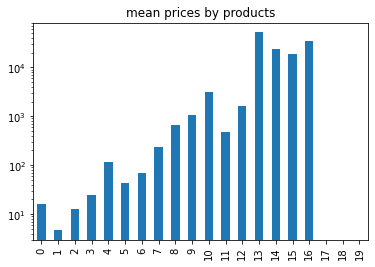

In [53]:
transactions_by_product["price"].plot.bar()
plt.yscale("log")
plt.title("mean prices by products")

Text(0.5, 1.0, 'cv by product')

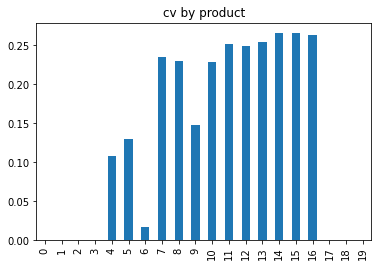

In [54]:
transactions_by_product["price_cv"].plot.bar()
plt.title("cv by product")

Text(0.5, 0.98, 'Prices for goods over time')

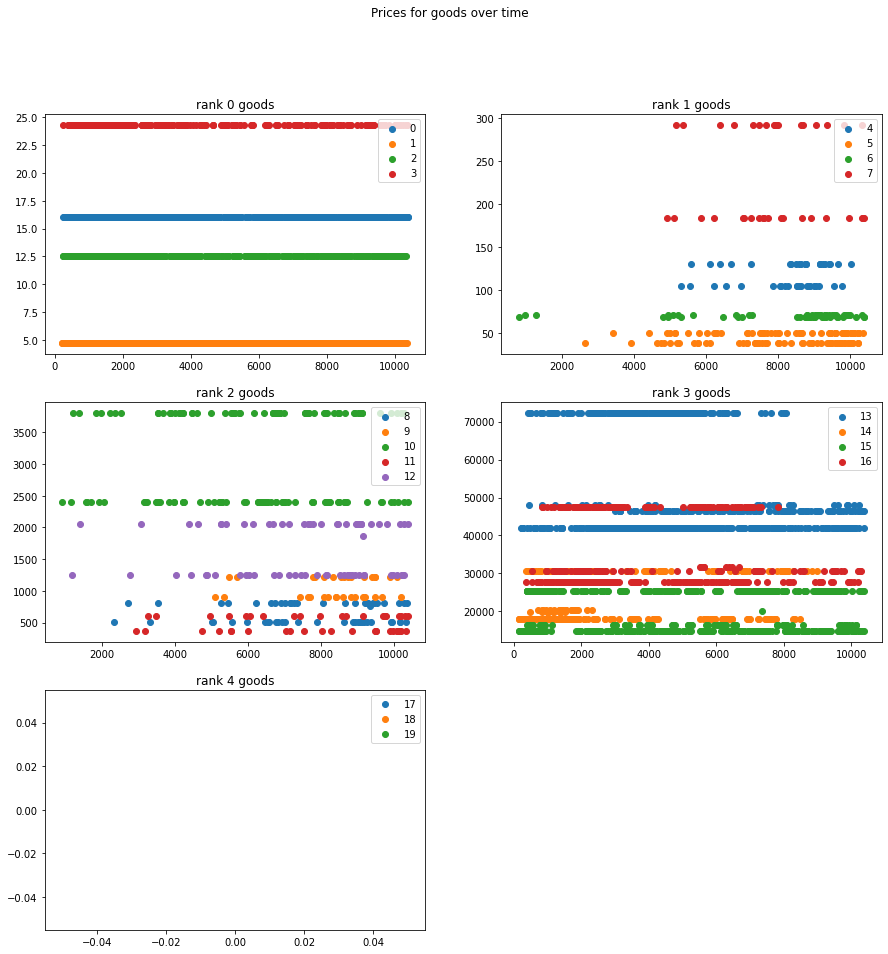

In [55]:
price_by_tick = transaction_df.groupby(["tick", "product"])["price"].mean().to_frame().reset_index()

a = np.insert(production_chain.ranks.cumsum(), 0,0)
rank_ranges = list(zip(a[0:-1], a[1:]))

fig, axs = plt.subplots(int(np.ceil(len(rank_ranges)/2)),2, figsize=(15,15))
if len(rank_ranges) % 2 == 1:
    fig.delaxes(axs.flatten()[-1])
for i,rng in enumerate(rank_ranges):
    ax = axs.flatten()[i]
    for product in range(rng[0], rng[1]):
        ax.scatter(price_by_tick[price_by_tick["product"] == product]["tick"], price_by_tick[price_by_tick["product"] == product]["price"], label=f'{product}')
    ax.title.set_text(f'rank {i} goods')
    ax.legend(loc="upper right")
    
fig.suptitle("Prices for goods over time")

In [56]:
buy_price_melt = buy_price_df.melt(id_vars=["agent", "tick"], value_vars=list(range(production_chain.ranks.sum())), var_name="product", value_name="price")
buy_price_melt = buy_price_melt[buy_price_melt["price"] > 0]
buy_price_by_tick = buy_price_melt.groupby(["tick", "product"])["price"].max()
sell_price_melt = sell_price_df.melt(id_vars=["agent", "tick"], value_vars=list(range(production_chain.ranks.sum())), var_name="product", value_name="price")
sell_price_melt = sell_price_melt[sell_price_melt["price"] < np.inf]
sell_price_by_tick = sell_price_melt.groupby(["tick", "product"])["price"].min()

Text(0.5, 0.98, 'Buy/sell price diffs for goods over time')

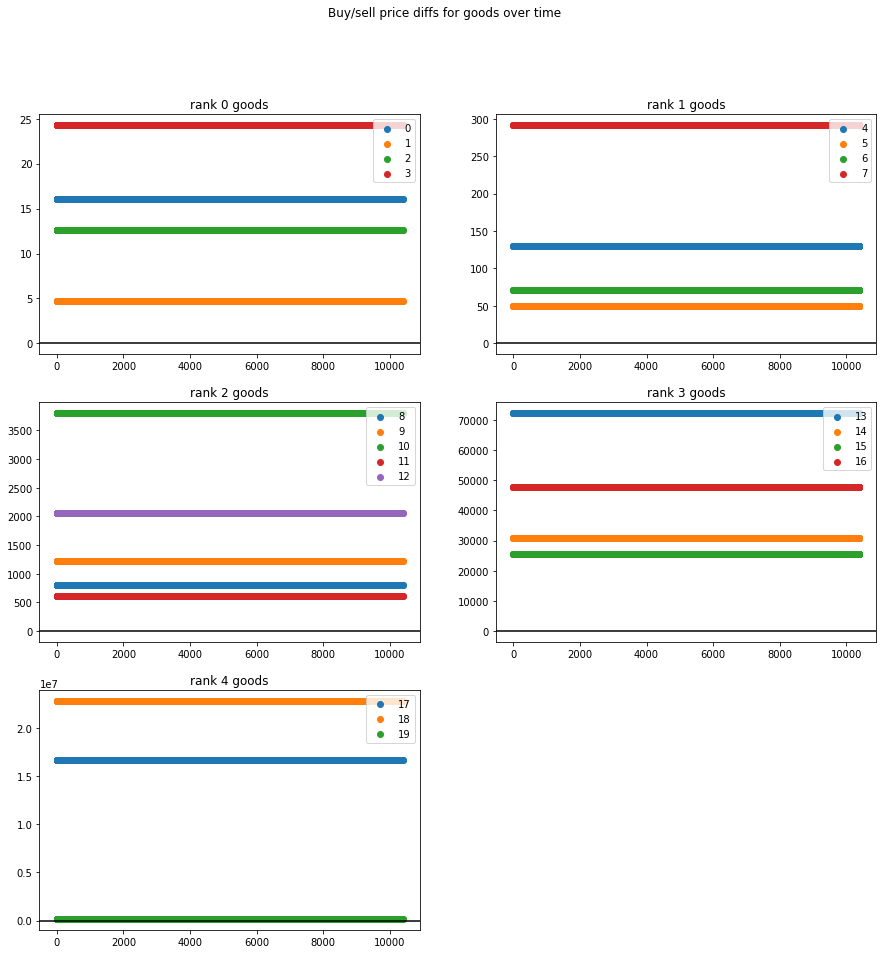

In [57]:
price_diffs = (buy_price_by_tick - sell_price_by_tick).to_frame().reset_index()

a = np.insert(production_chain.ranks.cumsum(), 0,0)
rank_ranges = list(zip(a[0:-1], a[1:]))

fig, axs = plt.subplots(int(np.ceil(len(rank_ranges)/2)),2, figsize=(15,15))
if len(rank_ranges) % 2 == 1:
    fig.delaxes(axs.flatten()[-1])
for i,rng in enumerate(rank_ranges):
    ax = axs.flatten()[i]
    for product in range(rng[0], rng[1]):
        ax.scatter(price_diffs[price_diffs["product"] == product]["tick"], price_diffs[price_diffs["product"] == product]["price"], label=f'{product}')
    ax.axhline(0, color="black")
    ax.title.set_text(f'rank {i} goods')
    ax.legend(loc="upper right")
    
fig.suptitle("Buy/sell price diffs for goods over time")

# Balance

In [58]:
balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")

,tick,balance
agent,,
0,0.033333,1.824838e+04
1,0.033333,0.000000e+00
2,0.033333,4.305820e+04
3,0.033333,2.170419e+04
4,0.033333,2.170419e+04
...,...,...
986,0.033333,0.000000e+00
987,0.033333,1.691162e+04
988,0.033333,1.691162e+04


In [59]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")

,tick,balance
agent,,
0,10384.566667,3.970354
1,10384.566667,0.000000
2,10384.566667,125368.428736
3,10384.566667,1.200673
4,10384.566667,1.200673
...,...,...
986,10384.566667,0.000000
987,10384.566667,34190.655741
988,10384.566667,34190.655741


In [60]:
#balance_df.groupby("tick")["balance"].sum().plot()

In [61]:
balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"].describe()

count    9.910000e+02
mean     4.455660e+06
std      1.866062e+07
min      0.000000e+00
25%      0.000000e+00
50%      1.691162e+04
75%      4.305820e+04
max      9.383996e+07
Name: balance, dtype: float64

In [62]:
balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"].describe()

count    9.910000e+02
mean     4.372540e+06
std      1.776151e+07
min      0.000000e+00
25%      0.000000e+00
50%      1.507422e+01
75%      7.536227e+04
max      9.572713e+07
Name: balance, dtype: float64

In [63]:
ltb_df = balance_df[balance_df["tick"] == balance_df["tick"].max()]

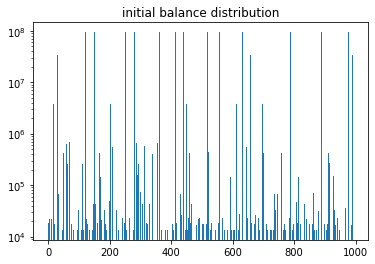

In [64]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].min()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"])
plt.title("initial balance distribution")
plt.yscale("log")

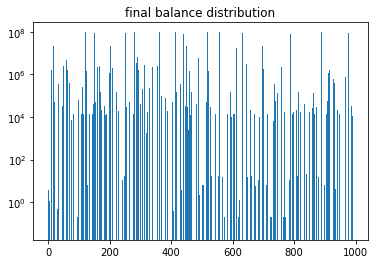

In [65]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].max()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"])
plt.title("final balance distribution")
plt.yscale("log")

In [66]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]-balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")["balance"]

agent
0     -1.824441e+04
1      0.000000e+00
2      8.231023e+04
3     -2.170299e+04
4     -2.170299e+04
           ...     
986    0.000000e+00
987    1.727904e+04
988    1.727904e+04
989   -3.422043e+07
990   -3.422043e+07
Name: balance, Length: 991, dtype: float64

<AxesSubplot:xlabel='agent'>

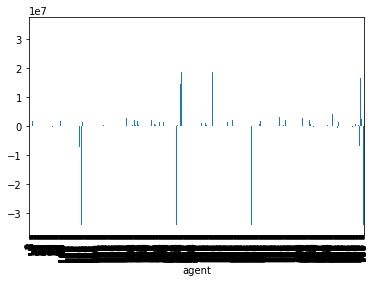

In [67]:
(balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]-balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")["balance"]).plot.bar()

In [68]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]

agent
0           3.970354
1           0.000000
2      125368.428736
3           1.200673
4           1.200673
           ...      
986         0.000000
987     34190.655741
988     34190.655741
989     11346.415752
990     11346.415752
Name: balance, Length: 991, dtype: float64

In [69]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].head(50)

,agent,tick,balance
5096713,0,10384.566667,3.970354e+00
5096714,1,10384.566667,0.000000e+00
5096715,2,10384.566667,1.253684e+05
5096716,3,10384.566667,1.200673e+00
5096717,4,10384.566667,1.200673e+00
5096718,5,10384.566667,1.158033e+01
5096719,6,10384.566667,1.138790e+07
5096720,7,10384.566667,0.000000e+00
5096721,8,10384.566667,0.000000e+00
5096722,9,10384.566667,8.310620e+05


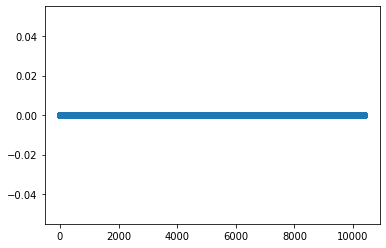

In [70]:
plt.scatter(balance_df[balance_df["agent"] == 1]["tick"],balance_df[balance_df["agent"] == 1]["balance"])

In [71]:
#for agent in balance_df["agent"].unique():
#    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"])


In [72]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].drop("tick", axis=1).set_index("agent") / balance_df[balance_df["tick"] == balance_df["tick"].min()].drop("tick", axis=1).set_index("agent")

,balance
agent,
0,0.000218
1,NaN
2,2.911604
3,0.000055
4,0.000055
...,...
986,NaN
987,2.021726
988,2.021726


# Inventory

## Last Tick Inventory

In [73]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()]

,agent,tick,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
5096713,0,10384.566667,0.0,0.0,0.0,1930.0,0.0,0.0,0.0,108.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5096714,1,10384.566667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5096715,2,10384.566667,0.0,0.0,0.0,0.0,0.0,262.0,0.0,0.0,...,0.0,216.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5096716,3,10384.566667,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5096717,4,10384.566667,0.0,0.0,0.0,17.0,0.0,0.0,0.0,585.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5097699,986,10384.566667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5097700,987,10384.566667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5097701,988,10384.566667,0.0,0.0,0.0,0.0,0.0,450.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5097702,989,10384.566667,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Produced Goods Inventory

In [74]:
agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,tick
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,216.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,585.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
988,0.0,0.0,0.0,0.0,0.0,450.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


### Input Resources Inventory

In [75]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,1930.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,262.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [76]:
(inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")) - (agent_goods_df @ production_chain_df.T)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,1924.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,256.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
987,0.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
988,0.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## Production Surplus/Deficit

In [77]:
agent_id = 22
target_tick = np.inf

target_tick = np.clip(target_tick, 0, inventory_df["tick"].max())

#inv_s = inventory_df[inventory_df["tick"] == target_tick].set_index("agent").loc[agent_id].drop("tick")
inv_s = inventory_df.drop("tick", axis=1).groupby("agent").mean().loc[agent_id]
need_s = (agent_goods_df.loc[agent_id] @ production_chain_df.T)
batch_s = (agent_goods_df * production_chain.batch_sizes[np.newaxis,:]).loc[agent_id] @ production_chain_df.T
deficit_df = pd.DataFrame({"inventory":inv_s, "unit_need":need_s, "batch_need": batch_s, "surplus":inv_s - batch_s, "batches":inv_s/batch_s})
deficit_df

,inventory,unit_need,batch_need,surplus,batches
0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,NaN
5,0.0,0.0,0.0,0.0,NaN
6,0.0,0.0,0.0,0.0,NaN
7,0.0,0.0,0.0,0.0,NaN
8,0.0,0.0,0.0,0.0,NaN
9,0.0,0.0,0.0,0.0,NaN


In [78]:
balance_df[(balance_df["agent"] == agent_id) & (balance_df["tick"] == target_tick)]

,agent,tick,balance
5096735,22,10384.566667,0.0


In [79]:
buy_price_df[(buy_price_df["tick"] == target_tick) & (buy_price_df["agent"] == agent_id)].T

,5096735
agent,22.000000
tick,10384.566667
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000


In [80]:
buy_budget_df[(buy_budget_df["tick"] == target_tick) & (buy_budget_df["agent"] == agent_id)].T

,5096735
agent,22.000000
tick,10384.566667
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000


In [81]:
inventory_df[inventory_df["agent"] == agent_id].drop("agent", axis=1).set_index("tick")[agent_id].describe()

KeyError: 22

# Buy and Sell Prices

In [ ]:
max_last_buy_price = buy_price_df[buy_price_df["tick"] == buy_price_df["tick"].max()].drop(["agent", "tick"], axis=1).max(axis=0)
min_last_sell_price = sell_price_df[sell_price_df["tick"] == sell_price_df["tick"].max()].drop(["agent", "tick"], axis=1).min(axis=0)
#max_last_buy_price - min_last_sell_price
min_last_sell_price

## Market Analysis for one Good

### Overview of one Market

In [ ]:
product_id = 3
min_ticks = 0
max_ticks = np.inf

max_ticks = np.clip(max_ticks, 0, sell_price_df["tick"].max())

dfsp = sell_price_df[(sell_price_df[product_id] < np.inf) & (sell_price_df["tick"].between(min_ticks,max_ticks))][["agent", "tick", product_id]].merge(inventory_df[["agent", "tick", product_id]], on=["tick", "agent"], suffixes=("","_inventory")).rename({str(product_id): product_id}, axis=1)
dfms = min_sell_price_df[(min_sell_price_df[product_id] < np.inf) & (min_sell_price_df["tick"].between(min_ticks,max_ticks))][["agent", "tick", product_id]].merge(inventory_df[["agent", "tick", product_id]], on=["tick", "agent"], suffixes=("","_inventory")).rename({str(product_id): product_id}, axis=1)

df1 = dfsp[dfsp[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].min().to_frame()
df1_mean = dfsp[dfsp[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].mean().to_frame()
df1_max = dfsp[dfsp[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].max().to_frame()
dfms = dfms[dfms[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].min().to_frame()
df2 = buy_price_df[(buy_price_df["tick"].between(min_ticks, max_ticks)) & (buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
df2[product_id] = df2[product_id]
dfmb = max_buy_price_df[(max_buy_price_df["tick"].between(min_ticks, max_ticks)) & (max_buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
dfmb[product_id] = dfmb[product_id]

buyer_df = buy_budget_df[(buy_budget_df[product_id] > 0) & buy_budget_df["tick"].between(min_ticks, max_ticks)][["tick", "agent", product_id]].merge(df2, on=["tick", "agent"], suffixes=["_budget", "_price"])
buyer_df["units"] = buyer_df[f'{product_id}_budget'] / buyer_df[f'{product_id}_price']
seller_df = inventory_df[inventory_df["tick"].between(min_ticks, max_ticks) & inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])].groupby("tick")[product_id].sum()
seller_df = seller_df.loc[min_ticks:max_ticks]


Seller prices

In [ ]:
sell_price_df[(sell_price_df[product_id] < np.inf) & sell_price_df["tick"].between(min_ticks, max_ticks)].groupby("agent")[product_id].describe()

Buyer Prices

In [ ]:
buyer_df.groupby("agent")[f'{product_id}_price'].describe()

#### Market Volume

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
plt.scatter(seller_df[seller_df>0].index, seller_df[seller_df>0], label=f'supply {seller_df.mean():.2f}')
for agent_id, color in zip(buyer_df["agent"].unique(), colors[1:]):
    plt.scatter(buyer_df[buyer_df["agent"] == agent_id]["tick"], buyer_df[buyer_df["agent"] == agent_id]["units"], label=f'{agent_id} demand {buyer_df[buyer_df["agent"] == agent_id]["units"].mean():.2f}', marker=".")
total_demand = buyer_df.groupby("tick")["units"].sum()
plt.scatter(total_demand.index, total_demand, label="total demand", marker=".", color="black")
plt.legend(loc="right")
plt.title(f'market volume for {product_id}')
print(seller_df.max())

In [ ]:
seller_df[seller_df > 0].index.to_series().describe()

In [ ]:
seller_df.describe()

In [ ]:
buyer_df.groupby("agent")["units"].describe()

In [ ]:
cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks) & cannot_buy_df["agent"].isin(np.where(production_goods[product_id])[0])][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

In [ ]:
df2[product_id].max()

In [ ]:
df2.groupby("tick")[product_id].describe().describe()

#### Market Price

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(15,5))
plt.scatter(df1.index, df1[product_id], label=f'min sell price {df1[product_id].mean():.2f}', color=colors[0])
plt.scatter(df1_mean.index, df1_mean[product_id], label=f'mean sell price {df1_mean[product_id].mean():.2f}', color=colors[0], marker=".")
plt.scatter(df1_mean.index, df1_max[product_id], label=f'max sell price {df1_max[product_id].mean():.2f}', color=colors[0], marker=".")
plt.scatter(dfms.index, dfms[product_id], label=f'min sell price {dfms[product_id].mean():.2f}', marker="_", color=colors[0])
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(df2[df2["agent"] == agent]["tick"], df2[df2["agent"] == agent][product_id], label=f'{agent} buy price {df2[df2["agent"] == agent][product_id].mean():.2f}', marker=".", color=color)
    plt.scatter(dfmb[dfmb["agent"] == agent]["tick"], dfmb[dfmb["agent"] == agent][product_id], label=f'{agent} max buy price {dfmb[dfmb["agent"] == agent][product_id].mean():.2f}', marker="_", color=color)
if len(df2) > 0:
    plt.ylim(0, df2[product_id].max()*1.1)
plt.ylim(plt.ylim()[0], plt.ylim()[1]*1.1)

#plt.legend(loc="right")
plt.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0)

# some status indicators
ax2 = plt.twinx()
print("is there a transaction?")
ax2.vlines(transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)]["tick"], ymin=0.98, ymax=1, color="gray")
print("do the sellers have inventory?")
ax2.vlines(seller_df[seller_df>0].index, ymin=0.96, ymax=0.98, color="darkblue")
print("do any buyers demand goods?")
ax2.vlines(buyer_df["tick"].unique()[(buyer_df.groupby("tick")["units"].sum() > 0)], ymin=0.94, ymax=0.96, color="darkred")
print("are prices compatible?")
price_diff = (df2.groupby("tick")[product_id].max() - df1[product_id]).rename("price_diff")
ax2.vlines(df1.join(price_diff[price_diff>0]).index, ymin=0.92, ymax=0.94, color="darkgreen")
print("is at least one agent in the cannot buy state (> 100 ticks)")
ax2.vlines(cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks)]["tick"].unique()[(cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks)].groupby("tick")[product_id].max() > 100)], ymin=0.90, ymax=0.92, color="darkred")
ax2.set_ylim(0,1)
plt.subplots_adjust(right=0.7)

plt.title(f'price chart for {product_id}')

#plt.tight_layout(rect=[0, 0, 0.75, 1])



In [ ]:
transaction_df[transaction_df["tick"].between(min_ticks, max_ticks) & (transaction_df["product"] == product_id)]

#### Ticks when max buy price changes a lot

In [ ]:
def consecutive_diffs(x):
    return x.iloc[1] - x.iloc[0]
    print(x)
    raise Exception(x.__class__)
mb_diffs = dfmb.set_index("tick").groupby("agent")[product_id].rolling(2).apply(consecutive_diffs)
mb_diffs.to_frame().sort_values(["agent", product_id], key=abs, ascending=False).groupby("agent").head(5)

#### Balance

In [ ]:
plt.subplots_adjust(right=0.7)
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
plt.scatter(df1.index, df1[product_id], label=f'sell price {df1[product_id].mean():.2f}', color=colors[0])
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"], color=color, label=f'{agent} balance ({balance_df[balance_df["agent"] == agent]["balance"].mean():.2f})')
plt.title(f'balance for buyers of {product_id}')
plt.legend(loc="right")
plt.ylim(0)

In [ ]:
np.where(agent_goods_df[product_id])

In [ ]:
plt.subplots_adjust(right=0.7)
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
#plt.scatter(df1.index, df1[product_id], label=f'sell price {df1[product_id].mean():.2f}', color=colors[0])
for agent, color in zip(np.where(agent_goods_df[product_id])[0], colors[1:]):
    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"], color=color, label=f'{agent} balance ({balance_df[balance_df["agent"] == agent]["balance"].mean():.2f})')
plt.title(f'balance for sellers of {product_id}')
plt.legend(loc="right")
plt.ylim(0)

### Sellers for the Market

In [ ]:
np.where(agent_goods_df[product_id] == 1)

Amounts Sold

In [ ]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("seller")["amount"].sum()

Time ranges of sales

In [ ]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("seller")["tick"].describe()

Prices for transactions

In [ ]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("seller")["price"].describe()

Desired sell prices

In [ ]:
sell_price_df[sell_price_df[product_id] < np.inf][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

Min Sell Prices

In [ ]:
min_sell_price_df[sell_price_df[product_id] < np.inf][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

Product inventory

In [ ]:
inventory_df[inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])].groupby("agent")[product_id].describe()

In [ ]:
for agent in np.where(agent_goods_df[product_id])[0]:
    plt.scatter(inventory_df[inventory_df["agent"] == agent]["tick"], inventory_df[inventory_df["agent"] == agent][product_id])

Input inventory

In [ ]:
production_needs = pd.Series(production_chain.adj_matrix[:,product_id] * production_chain.batch_sizes[product_id])
production_needs[production_needs > 0].to_frame()

In [ ]:
production_needs[production_needs > 0].index.to_list()

In [ ]:
input_ids = production_needs[production_needs > 0].index.to_list()
inventory_melt = pd.melt(inventory_df[inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])][["agent", "tick"]+input_ids], id_vars=["agent", "tick"], value_vars=input_ids, var_name="product")
input_inventory_info = inventory_melt.groupby(["agent", "product"])["value"].describe()
input_inventory_info

In [ ]:
inventory_melt.groupby(["agent","tick"])["value"].min().groupby("agent").describe()

Cannot sell ticks by seller

In [ ]:
relevant_cannot_sell_df = cannot_sell_df[cannot_sell_df["agent"].isin(np.where(agent_goods_df[product_id])[0])][["tick", "agent", product_id]]
relevant_cannot_sell_df.groupby("agent")[product_id].describe()

In [ ]:
plt.figure(figsize=(10,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
vtick = 0
vtick_step = 0.2
for agent, color in zip(relevant_cannot_sell_df["agent"].unique(), colors[1:]):
    plt.vlines(relevant_cannot_sell_df[(relevant_cannot_sell_df["agent"] == agent) & (relevant_cannot_sell_df[product_id]>100)]["tick"], ymin=vtick, ymax=vtick+vtick_step, label=f'{agent}', color=color)
    vtick += vtick_step
plt.legend()
plt.xlim(min_ticks, max_ticks)
plt.title(f'cannot sell {product_id}')

### Buyers for the Market

Total Amount Purchased

In [ ]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["amount"].sum()

Time Ranges of Purchase

In [ ]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["tick"].describe()

Prices Paid

In [ ]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["price"].describe()

Desired Buy Prices

In [ ]:
buy_price_df[buy_price_df[product_id] > 0][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

In [ ]:
max_buy_price_df[max_buy_price_df[product_id] > 0][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

Cannot buy ticks by buyer

In [ ]:
relevant_cannot_buy_df = cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks) & cannot_buy_df["agent"].isin(np.where(production_goods[product_id]>0)[0])][["tick", "agent", product_id]]
relevant_cannot_buy_df.groupby("agent")[product_id].describe()

Behavior of one buyer

In [ ]:
price_diff = (buy_price_df[buy_price_df["agent"] == agent].set_index("tick")[product_id] - sell_price_df.groupby("tick")[product_id].min())
price_diff[price_diff > 0].index

In [ ]:
agent_id = relevant_cannot_buy_df["agent"].unique()[0]
agent_output = agent_goods_df.loc[agent_id].idxmax()
plt.scatter(buy_budget_df[buy_budget_df["agent"] == agent_id]["tick"], buy_budget_df[buy_budget_df["agent"] == agent_id][product_id], label=f'buy budget')
plt.scatter(buy_price_df[buy_price_df["agent"] == agent_id]["tick"], buy_price_df[buy_price_df["agent"] == agent_id][product_id], label=f'buy price')
plt.scatter(inventory_df[inventory_df["agent"] == agent_id]["tick"], inventory_df[inventory_df["agent"] == agent_id][product_id], label=f'inventory')
plt.scatter(inventory_df[inventory_df["agent"] == agent_id]["tick"], inventory_df[inventory_df["agent"] == agent_id][agent_output], label=f'output_inventory')
plt.legend(loc="right")
ax2 = plt.twinx()

print("is transaction?")
ax2.vlines(transaction_df[(transaction_df["buyer"] == agent_id) & (transaction_df["product"] == product_id)]["tick"], ymin=0.95, ymax=1.0, color="green")
print("cannot buy?")
ax2.vlines(cannot_buy_df[(cannot_buy_df["agent"] == agent_id) & (cannot_buy_df[product_id] > 0)]["tick"], ymin=0.90, ymax=0.95, color="red")
print("has budget?")
ax2.vlines(buy_budget_df[(buy_budget_df["agent"] == agent_id) & (buy_budget_df[product_id] > 0)]["tick"], ymin=0.85, ymax=0.90, color="blue")
print("buy price at max price?")
ax2.vlines(buy_price_df[(buy_price_df["agent"] == agent_id) & (max_buy_price_df[product_id] - buy_price_df[product_id] < econ_sim.PRICE_EPS)]["tick"], ymin=0.80, ymax=0.85, color="purple")
price_diff = (buy_price_df[buy_price_df["agent"] == agent].set_index("tick")[product_id] - sell_price_df.groupby("tick")[product_id].min())
print("price compatible")
ax2.vlines(price_diff[price_diff > 0].index, ymin=0.75, ymax=0.80, color="yellow")
ax2.set_ylim(0,1)

plt.xlim(min_ticks, max_ticks)

plt.title(f'behavior for buyer {agent_id}')

In [ ]:
transaction_df[transaction_df["tick"].between(min_ticks, max_ticks) & (transaction_df["buyer"] == agent_id) & (transaction_df["product"] == product_id)]

In [ ]:
cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks) & (cannot_buy_df["agent"] == agent_id)].set_index("tick")[product_id].plot()

When cannot buy exceeds 0

In [ ]:
relevant_cannot_buy_df[relevant_cannot_buy_df[product_id] > 0].groupby("agent")["tick"].describe()

In [ ]:
plt.figure(figsize=(10,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
vtick = 0
vtick_step = 0.2
for agent, color in zip(relevant_cannot_buy_df["agent"].unique(), colors[1:]):
    plt.vlines(relevant_cannot_buy_df[(relevant_cannot_buy_df["agent"] == agent) & (relevant_cannot_buy_df[product_id]>100)]["tick"], ymin=vtick, ymax=vtick+vtick_step, label=f'{agent}', color=color)
    vtick += vtick_step
plt.legend()
plt.title(f'cannot buy {product_id}')
plt.xlim(min_ticks, max_ticks)

## Buy/Sell Price Investigation

In [ ]:
df1[product_id].describe()

In [ ]:
df2.groupby("agent")[product_id].describe()

In [ ]:
df2[df2["tick"] == df2["tick"].max()][product_id].max() - df1[product_id].iloc[-1]

In [ ]:
(df2.groupby("tick")[product_id].max() - df1[product_id]).describe()

In [ ]:
dfmb[dfmb["tick"] == dfmb["tick"].max()][product_id].max() - dfms[product_id].iloc[-1]

In [ ]:
(dfmb.groupby("tick")[product_id].max() - dfms[product_id]).describe()

In [ ]:
bp_s = (production_goods.loc[product_id] * buy_price_df[buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
mbp_s = (production_goods.loc[product_id] * max_buy_price_df[max_buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
sp_s = sell_price_df[sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
msp_s = min_sell_price_df[min_sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
price_df = pd.DataFrame({"cost":bp_s, "max_cost":mbp_s, "price":sp_s, "min_price":msp_s, "unit_profit":sp_s-bp_s})
price_df

## Larger Scale Market Analysis

In [ ]:
demand_units_df = (buy_budget_df.set_index(["agent", "tick"]) / buy_price_df.set_index(["agent", "tick"])).fillna(0.)
supply_units_df = (inventory_df.drop("tick", axis=1).set_index("agent") * agent_goods_df).rename_axis('agent').reset_index(level=0)
supply_units_df["tick"] = inventory_df["tick"]

### Supply Deficit

For each product, on average how many units of supply above demand are on the market

In [ ]:
transaction_df.groupby("product")["amount"].sum() / transaction_df["tick"].max()

In [ ]:
demand_units_mean = demand_units_df.groupby("tick").sum().mean()
supply_units_mean = supply_units_df.groupby("tick").sum().mean().drop("agent")
surplus_df = pd.DataFrame({
    "agents": agent_goods_df.sum(axis=0),
    "supply": supply_units_mean,
    "supply_cv": ((supply_units_df.groupby("tick").sum()).std()/(supply_units_df.groupby("tick").sum()).mean()).drop("agent"),
    "demand": demand_units_mean,
    "demand_cv": (demand_units_df.groupby("tick").sum()).std()/(demand_units_df.groupby("tick").sum()).mean(),
    "surplus": supply_units_mean - demand_units_mean
})
surplus_df["min_input_surplus"] = 1./(pd.DataFrame(production_chain.adj_matrix).replace(0, np.nan).multiply(1./surplus_df["surplus"], axis=0).max(axis=0).fillna(np.inf))
surplus_df

In [ ]:
surplus_df["surplus"] + surplus_df["min_input_surplus"]

## Cannot Buy or Sell

In [ ]:
cannot_buy_df.drop("tick", axis=1).groupby("agent").max().max(axis=1)

In [ ]:
cannot_buy_df.drop("tick", axis=1).groupby("agent").max().max(axis=1).hist(bins=int(np.sqrt(cannot_buy_df["agent"].nunique())))
plt.title("distribution of max cannot buy ticks for agents")

Summary of cannot buy by good

In [ ]:
maxes = cannot_buy_df.drop("tick", axis=1).groupby("agent").max()
describe_series = []
for product in agent_goods_df.columns:
    describe_series.append(maxes[product][production_goods[product] > 0].describe())
cannot_buy_summary = pd.concat(describe_series, axis=1).T
cannot_buy_summary["cv"] = cannot_buy_summary["std"] / cannot_buy_summary["mean"]
cannot_buy_summary["min_tick"] = transaction_df.groupby("product")["tick"].min()
cannot_buy_summary["max_tick"] = transaction_df.groupby("product")["tick"].max()
cannot_buy_summary

In [ ]:
cannot_sell_df.drop("tick", axis=1).groupby("agent").max().max(axis=1).hist(bins=int(np.sqrt(cannot_sell_df["agent"].nunique())))
plt.title("distribution of max cannot sell ticks for agents")

In [ ]:
#cannot_sell_df[cannot_sell_df["agent"].isin(np.where(agent_goods_df[0] > 0)[0])]
cannot_sell_df[cannot_sell_df["agent"].isin([0])].set_index("tick")[0].plot()

In [ ]:
transaction_df[(transaction_df["product"] == 0) & (transaction_df["seller"] == 0)].groupby("tick")["tick"].count()

In [ ]:
cannot_sell_df[(cannot_sell_df["agent"] == 0) & (cannot_sell_df["tick"] > 46026)]

Summary of cannot sell by product

In [ ]:
maxes = cannot_sell_df.drop("tick", axis=1).groupby("agent").max()
describe_series = []
for product in agent_goods_df.columns:
    describe_series.append(maxes[product][agent_goods_df[product] > 0].describe())
cannot_sell_summary = pd.concat(describe_series, axis=1).T
cannot_sell_summary["cv"] = cannot_sell_summary["std"] / cannot_sell_summary["mean"]
cannot_sell_summary["min_tick"] = transaction_df.groupby("product")["tick"].min()
cannot_sell_summary["max_tick"] = transaction_df.groupby("product")["tick"].max()
cannot_sell_summary

# Profit Analysis

## Basic Profit = Revenue - Cost

Sum up all revenue (from transactions, final goods are sunk elsewhere)
Sum up all costs (from transactions, basic resources are sourced elsewhere)
Account for inventory (using latest market prices)

profit = costs - revenue + value_of_goods_on_hand

In [ ]:
revenue = transaction_df.groupby("seller")["value"].sum().reindex(list(range(agent_goods_df.shape[0])), fill_value=0)
costs = transaction_df.groupby("buyer")["value"].sum().reindex(list(range(agent_goods_df.shape[0])), fill_value=0)

In [ ]:
costs.describe()

In [ ]:
revenue.describe()

Profit (without accounting for inventory value):

In [ ]:
(revenue-costs).describe()

In [ ]:
((revenue - costs)).hist(bins=int(np.sqrt(revenue.shape[0])))

How much value is sitting in inventory?

In [ ]:
# estimate based on last price in the market
value_of_goods_on_hand = (inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].drop("tick", axis=1).set_index("agent") * transaction_df.groupby("product")["price"].nth(-1)).fillna(0).sum(axis=1)
value_of_goods_on_hand.describe()

In [ ]:
revenue.mean() - costs.mean()

In [ ]:
value_of_goods_on_hand.mean()/revenue.mean()

Profit (accounting for value of goods on hand):

In [ ]:
((revenue - costs) + value_of_goods_on_hand).describe()

In [ ]:
((revenue - costs) + value_of_goods_on_hand).hist(bins=int(np.sqrt(revenue.shape[0])))

## Further Investigation

### Profit by Product

In [ ]:
revenue-costs

In [ ]:
agent_results = pd.DataFrame({"product":agent_goods, "profit":revenue-costs})
profit_by_product = agent_results.groupby("product")["profit"].describe().sort_values("mean")
profit_by_product["sem"] = agent_results.groupby("product").sem()
profit_by_product = profit_by_product.sort_values("mean", ascending=False)
profit_by_product

In [ ]:
plt.scatter(profit_by_product["count"], profit_by_product["mean"])
plt.xscale("log")
plt.yscale("symlog")

In [ ]:
xvals = np.arange(len(profit_by_product))
width = 0.2
plt.bar(list(map(lambda x: f'product {x}', profit_by_product.index.to_list())), profit_by_product["mean"], yerr=profit_by_product["sem"].fillna(0))
#ax2 = plt.twinx()
#ax2.bar(xvals + width, profit_by_product["std"], width=width)

### Who Made a Profit?

In [ ]:
print(len(np.where(((revenue - costs)) > 0)[0]))
np.where(((revenue - costs)) > 0)

In [ ]:
print(len(np.where(((revenue - costs) + value_of_goods_on_hand) > 0)[0]))
np.where(((revenue - costs) + value_of_goods_on_hand) > 0)

In [ ]:
revenue[((revenue - costs) + value_of_goods_on_hand) > 0].sort_values(ascending=False).head(10)

In [ ]:
costs[((revenue - costs) + value_of_goods_on_hand) > 0].sort_values(ascending=False)

top profit takers

In [ ]:
(revenue-costs).sort_values(ascending=False).head(20)

In [ ]:
agent_goods_df.loc[(revenue-costs).sort_values(ascending=False).head(20).index.to_series()].idxmax(axis=1)

Taking into account value of goods on hand:

In [ ]:
(revenue-costs+value_of_goods_on_hand).sort_values(ascending=False).head(20)

In [ ]:
agent_goods_df.loc[(revenue-costs+value_of_goods_on_hand).sort_values(ascending=False).head(20).index.to_series()].idxmax(axis=1)

### Who Made a Loss?

And selling what products?

In [ ]:
print(len(np.where(((revenue - costs)) < 0)[0]))
np.where(((revenue - costs)) < 0)

In [ ]:
print(len(np.where(((revenue - costs) + value_of_goods_on_hand) < 0)[0]))
np.where(((revenue - costs) + value_of_goods_on_hand) < 0)

In [ ]:
(revenue-costs).sort_values(ascending=True).head(20)

In [ ]:
agent_goods_df[((revenue - costs)) < 0].idxmax(axis=1).head(20)

In [ ]:
(revenue-costs + value_of_goods_on_hand).sort_values(ascending=True).head(20)

In [ ]:
agent_goods_df[((revenue - costs) + value_of_goods_on_hand) < 0].idxmax(axis=1)

## Recompute Profit from ending vs starting balance

And also account for value of goods on hand.

In [ ]:
(balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"]

In [ ]:
((balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"]).hist()

In [ ]:
((balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"] + value_of_goods_on_hand).hist()

## Profit By Prices

In [ ]:
production_goods

In [ ]:
(buy_price_df[buy_price_df["agent"] == 26].drop(["agent", "tick"], axis=1) * production_goods.loc[26]).sum(axis=1).plot()

In [ ]:
sell_price_df[sell_price_df["agent"] == 26][26].plot()

# Production Efficiency